In [6]:
import numpy as np
import pandas as pd
import xlrd

import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq
from scipy.signal import butter, lfilter, freqz
from scipy import signal

from sklearn.model_selection import train_test_split
import glob


cutoff_low = 60000 #in Hz
cutoff_high = 3000
# fs = 2380000
fs = 1140000
order = 5
NOISE_SIZE = 0
DATA_HEADERS_SIZE = 9

def get_fft_set(file_names):
    fft_set = []
    for files in file_names:
        data = pd.read_csv(files)
        fft_data = fft_from_data_frame(data)
        fft_set = fft_data + fft_set
    return fft_set

def fft_from_data_frame(data_frame):
    fs= 1.14e6
    signal_set = []
    nan_indexes = np.where(np.any(np.isnan(data_frame.values), axis=1))
    data_frame_values = np.delete(data_frame.values, nan_indexes, axis=0)
    for row in data_frame_values:
        fft_data = fft(row, n=row.size)/row.size
        freq = fftfreq(row.size, d=1/fs)
        cut_high_signal = abs(fft_data).copy()
        cut_high_signal[(freq > 50000)] = 0
        cut_high_signal[(freq < 30000)] = 0
        signal_without_0 = list(filter(lambda a: a != 0, cut_high_signal))
#         signal_set.append(np.abs(signal_without_0))
        signal_set.append(np.abs(cut_high_signal))
    return signal_set


def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass_filter(data):
    b, a = butter_lowpass(cutoff_low, fs, order=order)
    #y = lfilter(b, a, data)
    y = signal.filtfilt(b, a, data)
    
    b, a = butter_highpass(cutoff_high,fs,order)
    y_ = signal.filtfilt(b, a, y)
    return y_


def plot_graphs(data):
    fig = plt.figure(figsize=(30, 20))
    for index, data in enumerate(data):
        counter = 0
        if index < 30:
            ax = fig.add_subplot(7,7, index + 1)
            ax.plot(data[400:])
#             peaks, _ = find_peaks(data, height=0)
#             ax.plot(peaks, data[peaks])
            
def find_echo(data, window_size = 100):
    ECHO_SIZE = 1000
    rolling_max = data.rolling(window=ECHO_SIZE, axis=1).max()
    length = data.shape[1]
            
            
#Step 1 and 2
def get_time_domain_without_offset(data_frame):
    required_data_frame = data_frame.iloc[:, DATA_HEADERS_SIZE:]
    #print(data_frame)
    #print(required_data)
    return required_data_frame.sub(required_data_frame.mean(axis=1), axis=0)

#step 3
def pass_filter(data_frame):
    new_data= []
    for data in human_data_without_offset.values:
        new_data.append(butter_lowpass_filter(data))
    new_data = np.array(new_data)
#     plot_graphs(new_data)
    return new_data
    

In [2]:
human_data = glob.glob('../../data/1mhz_data/human/human_A/110/*.csv')
# '../../data/114KHz_Data/Human/Human_A/80/1.csv'
human_data = pd.read_csv('../../data/1mhz_data/human/human_A/80/1.csv', skiprows=[0], header= None)
human_data_without_offset = get_time_domain_without_offset(human_data)
# plot_graphs(human_data_without_offset.values)

In [5]:
filtered_values = pass_filter(human_data_without_offset)

In [55]:
from scipy.signal import find_peaks
THRESHOLD = 0.02

def validate_series(data_set_values, WINDOW_SIZE=100):
    valid_series = []
    dfObj = pd.DataFrame(data_set_values) 
    variance_list = dfObj.rolling(window=WINDOW_SIZE, axis=1).var()
    value = variance_list.values[0]
    peaks, _ = find_peaks(value, height=0.02)        
    plt.plot(value)
    plt.plot(peaks, value[peaks], "x")
    plt.plot(np.zeros_like(value), "--", color="gray")
    plt.show()
    for index, data in enumerate(variance_list.values):
        peaks, _ = find_peaks(data, height=THRESHOLD)
        if peaks.size > 0:
            valid_series.append(data_set_values[index])
    return valid_series

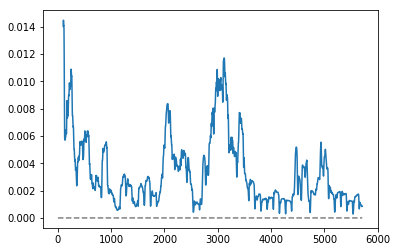

In [56]:
get_valid_series = validate_series(filtered_values)

In [54]:
len(get_valid_series)

396

In [57]:
49 -396

95